# Churn Prediction

### Loading Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, precision_score, recall_score, precision_recall_curve
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

### Loading Data

In [2]:
df = pd.read_csv('churn_prediction.csv')

In [3]:
df.head()

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,days_since_last_transaction,...,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn
0,1,3135,66,Male,0.0,self_employed,187.0,2,755,224.0,...,1458.71,1458.71,1449.07,0.20,0.20,0.20,0.20,1458.71,1458.71,0
1,2,310,35,Male,0.0,self_employed,NaN,2,3214,60.0,...,8704.66,7799.26,12419.41,0.56,0.56,5486.27,100.56,6496.78,8787.61,0
2,4,2356,31,Male,0.0,salaried,146.0,2,41,NaN,...,5815.29,4910.17,2815.94,0.61,0.61,6046.73,259.23,5006.28,5070.14,0
3,5,478,90,NaN,NaN,self_employed,1020.0,2,582,147.0,...,2291.91,2084.54,1006.54,0.47,0.47,0.47,2143.33,2291.91,1669.79,1
4,6,2531,42,Male,2.0,self_employed,1494.0,3,388,58.0,...,1401.72,1643.31,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16,1


In [4]:
df.shape

(28382, 21)

In [5]:
df.dtypes

customer_id                         int64
vintage                             int64
age                                 int64
gender                             object
dependents                        float64
occupation                         object
city                              float64
customer_nw_category                int64
branch_code                         int64
days_since_last_transaction       float64
current_balance                   float64
previous_month_end_balance        float64
average_monthly_balance_prevQ     float64
average_monthly_balance_prevQ2    float64
current_month_credit              float64
previous_month_credit             float64
current_month_debit               float64
previous_month_debit              float64
current_month_balance             float64
previous_month_balance            float64
churn                               int64
dtype: object

In [6]:
df.isna().sum()

customer_id                          0
vintage                              0
age                                  0
gender                             525
dependents                        2463
occupation                          80
city                               803
customer_nw_category                 0
branch_code                          0
days_since_last_transaction       3223
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
dtype: int64

There are quite a few missing values in columns gender, dependents, city, days since last transaction and Percentage change in credits. Lets find the appropriate missing value imputation strategy for each of them.

#### Gender

In [7]:
df['gender'].value_counts()

Male      16548
Female    11309
Name: gender, dtype: int64

So there is a good mix of males and females and arguably missing values cannot be filled with any one of them. We could create a seperate category by assigning the value -1 for all missing values in this column.

Before that, first we will convert the gender into 0/1 and then replace missing values with -1

In [8]:
#Convert Gender
dict_gender = {'Male': 1, 'Female':0}
df.replace({'gender': dict_gender}, inplace = True)

df['gender'] = df['gender'].fillna(-1)

#### Dependents, occupation and city with mode

Next we will have a quick look at the dependents & occupations column and impute with mode as this is sort of an ordinal variable

In [9]:
df['dependents'].value_counts()

0.0     21435
2.0      2150
1.0      1395
3.0       701
4.0       179
5.0        41
6.0         8
7.0         3
36.0        1
52.0        1
25.0        1
9.0         1
50.0        1
32.0        1
8.0         1
Name: dependents, dtype: int64

In [10]:
df['occupation'].value_counts()

self_employed    17476
salaried          6704
student           2058
retired           2024
company             40
Name: occupation, dtype: int64

In [11]:
df['dependents'] = df['dependents'].fillna(0)
df['occupation'] = df['occupation'].fillna('self_employed')

Similarly City can also be imputed with most common category 

In [12]:
df['city'].value_counts().head()

1020.0    3479
1096.0    2016
409.0     1334
146.0     1291
834.0     1138
Name: city, dtype: int64

In [13]:
df['city'] = df['city'].fillna(1020)

#### Days since Last Transaction
A fair assumption can be made on this column as this is number of days since last transaction in 1 year, we can substitute missing values with a value greater than 1 year say 999

In [14]:
df['days_since_last_transaction'] = df['days_since_last_transaction'].fillna(999)

### EDA

In [15]:
df.columns

Index(['customer_id', 'vintage', 'age', 'gender', 'dependents', 'occupation',
       'city', 'customer_nw_category', 'branch_code',
       'days_since_last_transaction', 'current_balance',
       'previous_month_end_balance', 'average_monthly_balance_prevQ',
       'average_monthly_balance_prevQ2', 'current_month_credit',
       'previous_month_credit', 'current_month_debit', 'previous_month_debit',
       'current_month_balance', 'previous_month_balance', 'churn'],
      dtype='object')

In [16]:
cols = list(df.columns[7:20])
cols.remove("branch_code")
cols.remove("days_since_last_transaction")
len(cols)

11

In [17]:
sns.set_style("darkgrid")

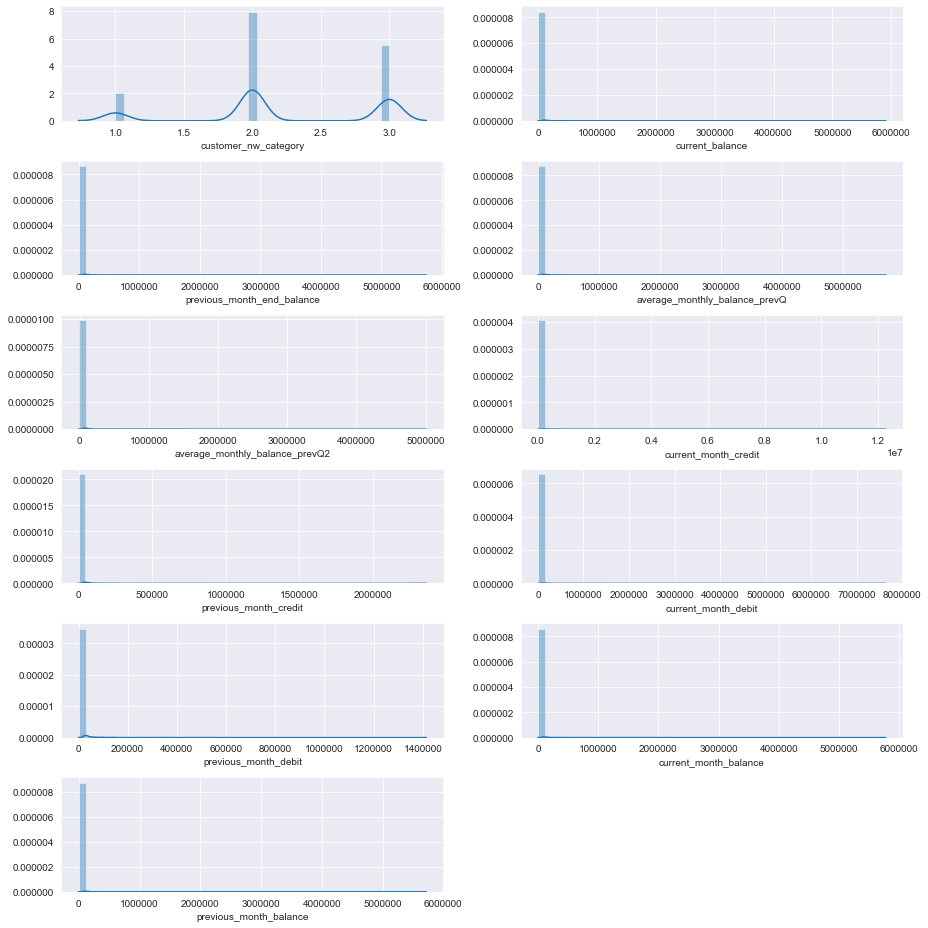

In [18]:
plt.figure(figsize=(13,13))
for i, col in enumerate(cols, 1):
    plt.subplot(6,2,i)
    sns.distplot(df[col])
    plt.tight_layout()

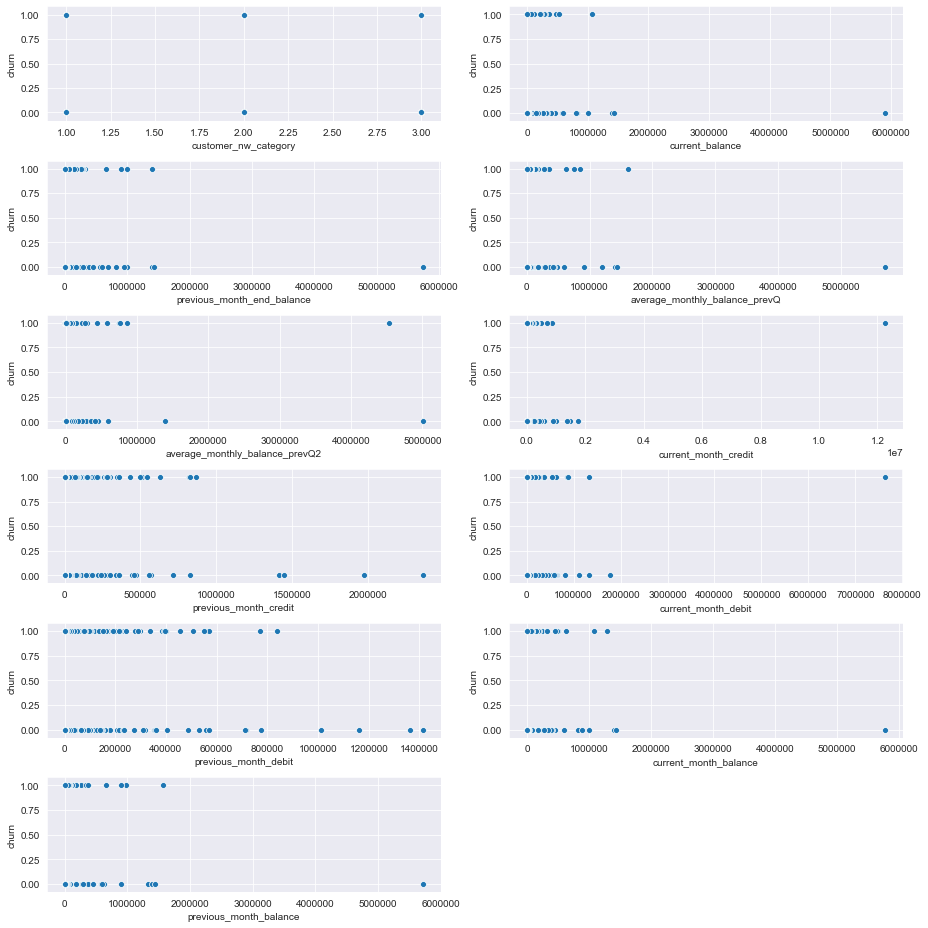

In [19]:
plt.figure(figsize=(13,13))
for i, col in enumerate(cols, 1):
    plt.subplot(6,2,i)
    sns.scatterplot(df[col], df["churn"])
    plt.tight_layout()

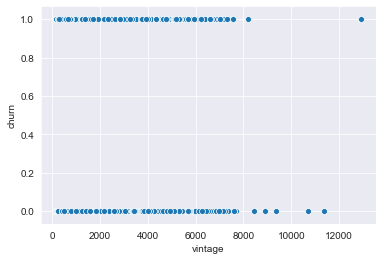

In [20]:
sns.scatterplot(df["vintage"], df["churn"])

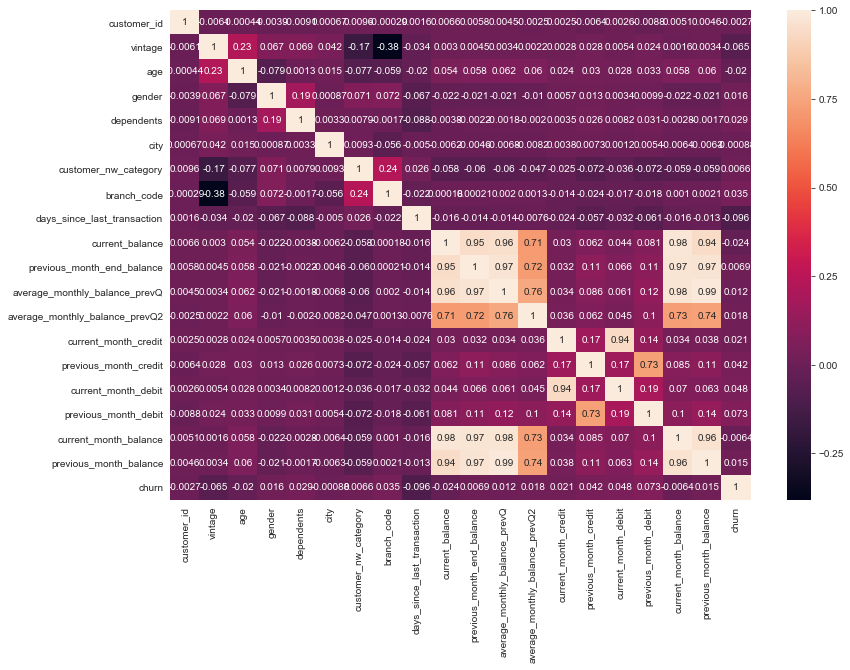

In [22]:
plt.figure(figsize=(13,9))
sns.heatmap(df.corr(), annot=True)

### Preprocessing

Now, before applying linear model such as logistic regression, we need to scale the data and keep all features as numeric strictly. 


### Dummies with Multiple Categories

In [24]:
df['occupation'].value_counts()

self_employed    17556
salaried          6704
student           2058
retired           2024
company             40
Name: occupation, dtype: int64

In [25]:
# Convert occupation to one hot encoded features
df = pd.concat([df,pd.get_dummies(df['occupation'],prefix = str('occupation'),prefix_sep='_')],axis = 1)

In [26]:
df.head()

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,days_since_last_transaction,...,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn,occupation_company,occupation_retired,occupation_salaried,occupation_self_employed,occupation_student
0,1,3135,66,1.0,0.0,self_employed,187.0,2,755,224.0,...,0.20,0.20,1458.71,1458.71,0,0,0,0,1,0
1,2,310,35,1.0,0.0,self_employed,1020.0,2,3214,60.0,...,5486.27,100.56,6496.78,8787.61,0,0,0,0,1,0
2,4,2356,31,1.0,0.0,salaried,146.0,2,41,999.0,...,6046.73,259.23,5006.28,5070.14,0,0,0,1,0,0
3,5,478,90,-1.0,0.0,self_employed,1020.0,2,582,147.0,...,0.47,2143.33,2291.91,1669.79,1,0,0,0,1,0
4,6,2531,42,1.0,2.0,self_employed,1494.0,3,388,58.0,...,588.62,1538.06,1157.15,1677.16,1,0,0,0,1,0


### Scaling Numerical Features for Logistic Regression

There are a lot of outliers in the dataset especially when it comes to previous and current balance features. Also, the distributions are skewed for these features (check EDA). We will take 2 steps to deal with that here:
* Log Transformation
* Standard Scaler

Standard scaling is anyways a necessity when it comes to linear models and we have done that here after doing log transformation on all balance features.

In [27]:
df.dtypes

customer_id                         int64
vintage                             int64
age                                 int64
gender                            float64
dependents                        float64
occupation                         object
city                              float64
customer_nw_category                int64
branch_code                         int64
days_since_last_transaction       float64
current_balance                   float64
previous_month_end_balance        float64
average_monthly_balance_prevQ     float64
average_monthly_balance_prevQ2    float64
current_month_credit              float64
previous_month_credit             float64
current_month_debit               float64
previous_month_debit              float64
current_month_balance             float64
previous_month_balance            float64
churn                               int64
occupation_company                  uint8
occupation_retired                  uint8
occupation_salaried               

In [28]:
num_cols = list(df.columns[7:20])
num_cols.remove('branch_code')
num_cols.remove('days_since_last_transaction')
num_cols

['customer_nw_category',
 'current_balance',
 'previous_month_end_balance',
 'average_monthly_balance_prevQ',
 'average_monthly_balance_prevQ2',
 'current_month_credit',
 'previous_month_credit',
 'current_month_debit',
 'previous_month_debit',
 'current_month_balance',
 'previous_month_balance']

In [29]:
for i in num_cols:
    df[i] = np.log(df[i] + 17000)

scaler = StandardScaler()
scaled = scaler.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

In [30]:
df = df.drop(columns = num_cols,axis = 1)
df = df.merge(scaled,left_index=True,right_index=True,how = "left")

In [31]:
y = df.churn
df = df.drop(['churn','customer_id','occupation'],axis = 1)

## Model Building and Evaluation Metrics
Since this is a binary classification problem, we could use the following 2 popular metrics:

1. Recall
2. Area under the Receiver operating characteristic curve

Now, we are looking at the recall value here because a customer falsely marked as churn would not be as bad as a customer who was not detected as a churning customer and appropriate measures were not taken by the bank to stop him/her from churning

The ROC AUC is the area under the curve when plotting the (normalized) true positive rate (x-axis) and the false positive rate (y-axis).

Our main metric here would be Recall values, while AUC ROC Score would take care of how well predicted probabilites are able to differentiate between the 2 classes.

### Conclusions from EDA
* For debit values, we see that there is a significant difference for churn and non churn and it might turn out to be an important feature
* For all the balance features the lower values have much higher proportion of churning customers
* For most frequent vintage values, the churning customers are slightly higher, while for higher values of vintage, we have mostly non churning customers which is in sync with the age variable 

Now, we will first split our dataset into test and train and using the above conclusions select columns and build a baseline logistic regression model to check the ROC-AUC Score & the confusion matrix

### Baseline Columns

In [32]:
baseline_cols = ['current_month_debit', 'previous_month_debit','current_balance','previous_month_end_balance','vintage'
                 ,'occupation_retired', 'occupation_salaried','occupation_self_employed', 'occupation_student']

In [33]:
df_baseline = df[baseline_cols]

### Train Test Split to create a validation set

In [34]:
# Splitting the data into Train and Validation set
X_train, X_test, y_train, y_test = train_test_split(df_baseline, y, test_size=1/3, random_state=11, stratify = y)

In [35]:
model = LogisticRegression()
model.fit(X_train,y_train)
pred = model.predict_proba(X_test)[:,1]

### AUC ROC Curve & Confusion Matrix 

Now, let us quickly look at the AUC-ROC curve for our logistic regression model and also the confusion matrix to see where the logistic regression model is failing here.

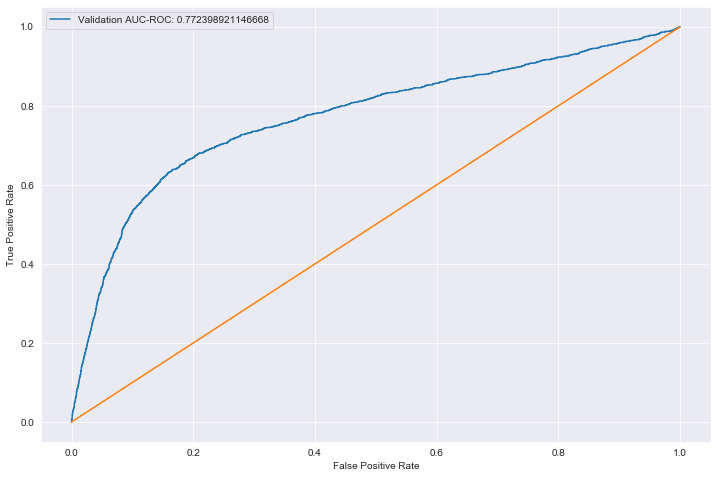

In [36]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test,pred) 
auc = roc_auc_score(y_test, pred) 
plt.figure(figsize=(12,8)) 
plt.plot(fpr, tpr, label="Validation AUC-ROC: "+ str(auc)) 
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend() 

In [37]:
# Confusion Matrix
pred_val = model.predict(X_test)

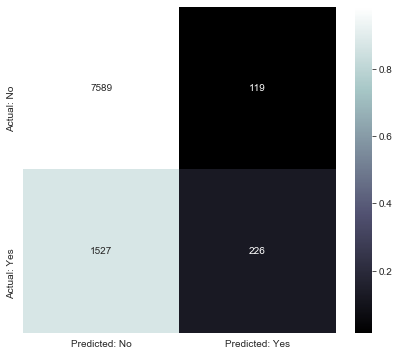

In [38]:
label_preds = pred_val

cm = confusion_matrix(y_test,label_preds)


def plot_confusion_matrix(cm, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=['Predicted: No','Predicted: Yes'], yticklabels=['Actual: No','Actual: Yes'], cmap=cmap)

plot_confusion_matrix(cm, ['No', 'Yes'])

In [39]:
# Recall Score
recall_score(y_test,pred_val)

0.1289218482601255

### Cross validation


Cross Validation is one of the most important concepts in any type of data modelling. It simply says, try to leave a sample on which you do not train the model and test the model on this sample before finalizing the model.

We divide the entire population into k equal samples. Now we train models on k-1 samples and validate on 1 sample. Then, at the second iteration we train the model with a different sample held as validation. 

In k iterations, we have basically built model on each sample and held each of them as validation. This is a way to reduce the selection bias and reduce the variance in prediction power.

Since it builds several models on different subsets of the dataset, we can be more sure of our model performance if we use CV for testing our models.

In [40]:
def cv_score(ml_model, rstate = 12, thres = 0.5, cols = df.columns):
    i = 1
    cv_scores = []
    df1 = df.copy()
    df1 = df[cols]
    
    # 5 Fold cross validation stratified on the basis of target
    kf = StratifiedKFold(n_splits=5, random_state=rstate, shuffle=True)
    
    for df_index, test_index in kf.split(df1, y):
        print('\n{} of kfold {}'.format(i, kf.n_splits))
        xtr, xvl = df1.loc[df_index], df1.loc[test_index]
        ytr, yvl = y.loc[df_index], y.loc[test_index]
            
        # Define model for fitting on the training set for each fold
        model = ml_model
        model.fit(xtr, ytr)
        pred_probs = model.predict_proba(xvl)
        pp = []
         
        # Use threshold to define the classes based on probability values
        for j in pred_probs[:,1]:
            if j>thres:
                pp.append(1)
            else:
                pp.append(0)
         
        # Calculate scores for each fold and print
        pred_val = pp
        roc_score = roc_auc_score(yvl,pred_probs[:,1])
        recall = recall_score(yvl,pred_val)
        precision = precision_score(yvl,pred_val)
        sufix = ""
        msg = ""
        msg += "ROC AUC Score: {}, Recall Score: {:.4f}, Precision Score: {:.4f} ".format(roc_score, recall,precision)
        print("{}".format(msg))
         
         # Save scores
        cv_scores.append(roc_score)
        i+=1
    return cv_scores

In [41]:
baseline_scores = cv_score(LogisticRegression(), cols = baseline_cols)


1 of kfold 5
ROC AUC Score: 0.7676540951597985, Recall Score: 0.1245, Precision Score: 0.6453 

2 of kfold 5
ROC AUC Score: 0.7683635803103483, Recall Score: 0.1359, Precision Score: 0.6714 

3 of kfold 5
ROC AUC Score: 0.771339728577631, Recall Score: 0.1321, Precision Score: 0.6178 

4 of kfold 5
ROC AUC Score: 0.7688323526122594, Recall Score: 0.1312, Precision Score: 0.6699 

5 of kfold 5
ROC AUC Score: 0.7579209398476456, Recall Score: 0.1236, Precision Score: 0.6341 


Now let us try using all columns available to check if we get significant improvement.

In [42]:
all_feat_scores = cv_score(LogisticRegression())


1 of kfold 5
ROC AUC Score: 0.7911275305723976, Recall Score: 0.2129, Precision Score: 0.7273 

2 of kfold 5
ROC AUC Score: 0.7958072140581646, Recall Score: 0.2177, Precision Score: 0.7068 

3 of kfold 5
ROC AUC Score: 0.7959476594261055, Recall Score: 0.1901, Precision Score: 0.7117 

4 of kfold 5
ROC AUC Score: 0.7925069812648835, Recall Score: 0.1996, Precision Score: 0.7167 

5 of kfold 5
ROC AUC Score: 0.7955383632428592, Recall Score: 0.2186, Precision Score: 0.7516 


There is some improvement in both ROC AUC Scores and Precision/Recall Scores. Now we can try backward selection to select the best subset of features which give the best score. 

### Reverse Feature Elimination or Backward Selection

We have already built a model using all the features and a separate model using some baseline features. We can try using backward feature elimination to check if we can do better. Let's do that next.

In [43]:
from sklearn.feature_selection import RFE

# Create the RFE object and rank each feature
model = LogisticRegression()
rfe = RFE(estimator=model, n_features_to_select=1, step=1)
rfe.fit(df, y)

RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 l1_ratio=None, max_iter=100,
                                 multi_class='warn', n_jobs=None, penalty='l2',
                                 random_state=None, solver='warn', tol=0.0001,
                                 verbose=0, warm_start=False),
    n_features_to_select=1, step=1, verbose=0)

In [44]:
ranking_df = pd.DataFrame()
ranking_df['Feature_name'] = df.columns
ranking_df['Rank'] = rfe.ranking_

In [45]:
ranked = ranking_df.sort_values(by=['Rank'])

In [46]:
ranked

,Feature_name,Rank
13,current_balance,1
15,average_monthly_balance_prevQ,2
7,occupation_company,3
16,average_monthly_balance_prevQ2,4
21,current_month_balance,5
22,previous_month_balance,6
19,current_month_debit,7
8,occupation_retired,8
20,previous_month_debit,9
11,occupation_student,10


The balance features are proving to be very important as can be seen from the table. The RFE function can also be used to select features. Lets select the top 10 features from this table and check score.

In [47]:
rfe_top_10_scores = cv_score(LogisticRegression(), cols = ranked['Feature_name'][:10].values)


1 of kfold 5
ROC AUC Score: 0.7898692837324015, Recall Score: 0.2015, Precision Score: 0.7114 

2 of kfold 5
ROC AUC Score: 0.7953638886034323, Recall Score: 0.2101, Precision Score: 0.7038 

3 of kfold 5
ROC AUC Score: 0.8111329384135672, Recall Score: 0.2253, Precision Score: 0.7292 

4 of kfold 5
ROC AUC Score: 0.7962611585117161, Recall Score: 0.2177, Precision Score: 0.7316 

5 of kfold 5
ROC AUC Score: 0.8014342017840461, Recall Score: 0.2262, Precision Score: 0.7301 


The recall score here is quite low. We should play around with the threshold to get a better recall score. AUC ROC depends on the predicted probabilities and is not impacted by the threshold.

In [48]:
cv_score(LogisticRegression(), cols = ranked['Feature_name'][:10].values, thres=0.14)


1 of kfold 5
ROC AUC Score: 0.7898692837324015, Recall Score: 0.7994, Precision Score: 0.2930 

2 of kfold 5
ROC AUC Score: 0.7953638886034323, Recall Score: 0.8165, Precision Score: 0.2974 

3 of kfold 5
ROC AUC Score: 0.8111329384135672, Recall Score: 0.8479, Precision Score: 0.2903 

4 of kfold 5
ROC AUC Score: 0.7962611585117161, Recall Score: 0.8127, Precision Score: 0.2915 

5 of kfold 5
ROC AUC Score: 0.8014342017840461, Recall Score: 0.8356, Precision Score: 0.2863 


[0.7898692837324015,
 0.7953638886034323,
 0.8111329384135672,
 0.7962611585117161,
 0.8014342017840461]

We observe that there is continuous improvement in the Recall Score. However, clearly precision score is going down. On the basis of business requirement the bank can take a call on deciding the threshold.

## Comparison of Different model fold wise

Let us visualise the cross validation scores for each fold for the following 3 models and observe differences:
* Baseline Model
* Model based on all features
* Model based on top 10 features obtained from RFE

In [49]:
results_df = pd.DataFrame({'baseline':baseline_scores, 'all_feats': all_feat_scores, 'rfe_top_10': rfe_top_10_scores})

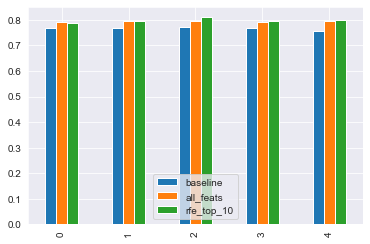

In [50]:
results_df.plot(y=["baseline", "all_feats", "rfe_top_10"], kind="bar")